In [1]:
# Data Cleaning

## 1. Import & Load
## 2. Handle Missing Values
## 3. Outlier Treatment (cap/remove)
## 4. Feature Formatting / Encoding
## 5. Save Cleaned Dataset

In [2]:
import pandas as pd
from abc import ABC, abstractmethod
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures

In [3]:
class DataLoader(ABC):

    @abstractmethod
    def load_data(self):
        pass

    def _clean_data(self, df):
        """ENCAPSULATION: A protected method for internal cleaning steps."""
        df.columns = [col.lower().replace(' ', '_') for col in df.columns]

        print("Basic cleaning applied.")
        return df

class WineCSVLoader(DataLoader):

    def __init__(self, filepath, target_col="quality", sep=','):
        self.filepath = filepath
        self.target_col = target_col
        self.sep = sep  # <-- store separator

    def load_data(self):
        df = pd.read_csv(self.filepath, sep=self.sep)
        print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns from {self.filepath}")
        df = self._clean_data(df)
        return df

In [4]:
loader = WineCSVLoader(filepath="../data/raw/winequalityN.csv", sep=';', target_col="quality")
wine_pro = loader.load_data()
wine_pro.head()

Loaded 1599 rows and 12 columns from ../data/raw/winequalityN.csv
Basic cleaning applied.


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
wine_pro.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
wine_pro.dropna()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


no missing values 

In [7]:
class DataCleaner:
    def __init__(self, dataframe):
        self.df = dataframe .copy()

    def handle_missing(self, strategy = "drop", columns = None):
        if strategy == "drop":
            self.df = self.df.dropna()
        elif strategy == "median":
            for col in columns or self.df.select_dtypes(include='number').columns:
                self.df[col] = self.df[col].fillna(self.df[col].median())
        elif strategy == "mode":
            for col in columns or self.df.columns:
                self.df[col] = self.df[col].fillna(self.df[col].mode()[0])
        return self
    
    def cap_outliers_iqr(self):
        for col in self.df.select_dtypes(include='number').columns:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            self.df[col] = np.where(self.df[col] < lower, lower,
                             np.where(self.df[col] > upper, upper, self.df[col]))
        return self
    
    def remove_outliers_iqr(self):
        for col in self.df.select_dtypes(include='number').columns:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            self.df = self.df[(self.df[col] >= lower) & (self.df[col] <= upper)]
        return self
    
    def format_columns(self):
        self.df.columns = self.df.columns.str.lower().str.replace(' ', '_')
        return self

    def save(self, path):
        self.df.to_csv(path, index=False)
        print(f"✅ Saved cleaned data to {path}")
        return self

    def get_data(self):
        return self.df

In [8]:
wine_cleaned = DataCleaner(wine_pro)
clean_df = (
    wine_cleaned
    .handle_missing(strategy="median")
    .cap_outliers_iqr()
    .format_columns()
    .save("../data/wine_pro_cleaned.csv")
    .get_data()
)

clean_df.head()

✅ Saved cleaned data to ../data/wine_pro_cleaned.csv


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0


In [9]:
clean_wine = clean_df.copy

In [10]:
#cateogirize quality(target)
def categorize_quality(quality):
    if quality in [3, 4]:
        return 0  # Low
    elif quality in [5, 6]:
        return 1  # Medium
    elif quality in [7, 8, 9]:
        return 2  # High

clean_df['quality_category'] = clean_df['quality'].apply(categorize_quality)
print(clean_df['quality_category'].value_counts().sort_index())

quality_category
0.0      53
1.0    1319
2.0     199
Name: count, dtype: int64


In [11]:
clean_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,quality_category
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0,1.0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5.0,1.0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5.0,1.0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6.0,1.0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5.0,1.0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6.0,1.0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6.0,1.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5.0,1.0


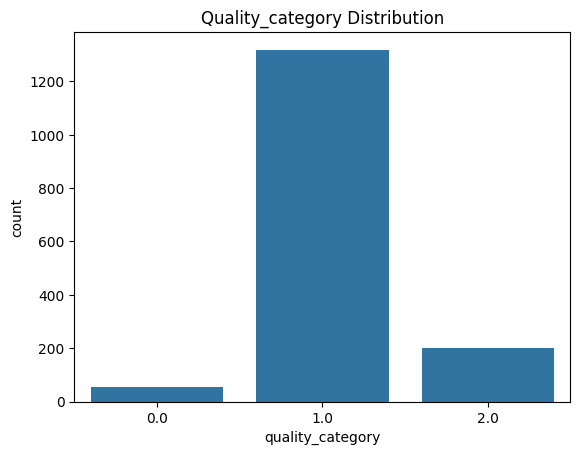

In [12]:
sns.countplot(x = "quality_category", data = clean_df)
plt.title("Quality_category Distribution")
plt.show()

In [13]:
clean_df.dropna()
clean_df.dropna(subset = ["quality_category"])

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,quality_category
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0,1.0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5.0,1.0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5.0,1.0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6.0,1.0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5.0,1.0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6.0,1.0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6.0,1.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5.0,1.0


In [14]:
#feature egineering 
# New features
clean_df['total_acidity'] =clean_df['fixed_acidity'] + clean_df['volatile_acidity'] + clean_df['citric_acid']
clean_df['so2_ratio'] = clean_df['free_sulfur_dioxide'] / (clean_df['total_sulfur_dioxide'] + 1)
clean_df['density_alcohol_ratio'] = clean_df['density'] / (clean_df['alcohol'] + 1e-3)
clean_df['acid_alcohol_balance'] = clean_df['alcohol'] / (clean_df['volatile_acidity'] + 1e-3)
clean_df['sugar_acid_ratio'] = clean_df['residual_sugar'] / (clean_df['fixed_acidity'] + 1e-3)
clean_df['total_preservatives'] = clean_df['free_sulfur_dioxide'] + clean_df['total_sulfur_dioxide']
clean_df['acidity_strength'] = clean_df['fixed_acidity'] - clean_df['ph']
clean_df['sulphate_density_ratio'] = clean_df['sulphates'] / (clean_df['density'] + 1e-3)
clean_df


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,...,quality,quality_category,total_acidity,so2_ratio,density_alcohol_ratio,acid_alcohol_balance,sugar_acid_ratio,total_preservatives,acidity_strength,sulphate_density_ratio
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,...,5.0,1.0,8.100,0.314286,0.106138,13.409415,0.256722,45.0,3.89,0.560673
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,...,5.0,1.0,8.680,0.367647,0.101704,11.123723,0.333291,92.0,4.60,0.681499
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,...,5.0,1.0,8.600,0.272727,0.101724,12.877792,0.294834,69.0,4.54,0.651303
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,...,6.0,1.0,12.040,0.278689,0.101826,34.875445,0.169628,77.0,8.04,0.580581
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,...,5.0,1.0,8.100,0.314286,0.106138,13.409415,0.256722,45.0,3.89,0.560673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,...,5.0,1.0,6.880,0.711111,0.094743,17.470882,0.322529,76.0,2.75,0.582388
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,...,6.0,1.0,6.550,0.750000,0.088842,20.326679,0.372818,90.0,2.38,0.762960
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,...,6.0,1.0,6.940,0.707317,0.090514,21.526419,0.365021,69.0,2.88,0.752453
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,...,5.0,1.0,6.665,0.711111,0.097586,15.789474,0.338926,76.0,2.33,0.712515


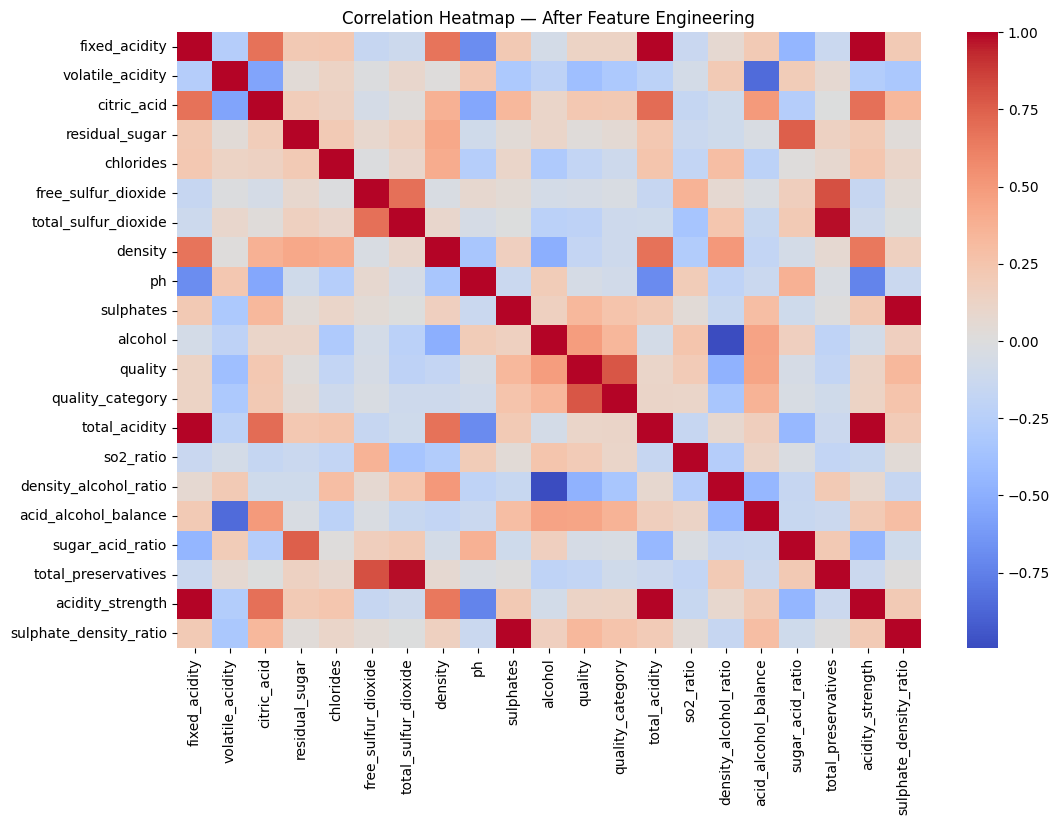

In [15]:
#checking for multicollinearity amongst the features
corr = clean_df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap — After Feature Engineering")
plt.show()

In [16]:
#dropping one of each pair with very high correlation
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col].abs() > 0.9)]
print("Highly correlated features to drop:", to_drop)

clean_df.drop(columns=to_drop, inplace=True)

Highly correlated features to drop: ['total_acidity', 'density_alcohol_ratio', 'total_preservatives', 'acidity_strength', 'sulphate_density_ratio']


In [17]:
clean_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,quality_category,so2_ratio,acid_alcohol_balance,sugar_acid_ratio
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0,1.0,0.314286,13.409415,0.256722
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5.0,1.0,0.367647,11.123723,0.333291
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5.0,1.0,0.272727,12.877792,0.294834
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6.0,1.0,0.278689,34.875445,0.169628
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0,1.0,0.314286,13.409415,0.256722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5.0,1.0,0.711111,17.470882,0.322529
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6.0,1.0,0.750000,20.326679,0.372818
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6.0,1.0,0.707317,21.526419,0.365021
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5.0,1.0,0.711111,15.789474,0.338926


In [18]:
#revalidate correlations with target 
target_corr = clean_df.corr(numeric_only=True)['quality_category'].sort_values(ascending=False)
print(target_corr)

quality_category        1.000000
quality                 0.788777
acid_alcohol_balance    0.361729
alcohol                 0.342106
sulphates               0.256622
citric_acid             0.219939
fixed_acidity           0.130191
so2_ratio               0.109645
residual_sugar          0.053883
free_sulfur_dioxide    -0.030466
sugar_acid_ratio       -0.040070
ph                     -0.084674
density                -0.106502
total_sulfur_dioxide   -0.106852
chlorides              -0.107388
volatile_acidity       -0.311375
Name: quality_category, dtype: float64


In [19]:
clean_df.to_csv("../data/processed/winequality_with_quality_category.csv", index=False)

In [20]:
# Define features (X) and target variable (y)
X = clean_df.drop(columns= ['quality_category', 'quality']) #because we created Age Group above and CustomerID is just an identifier
y = clean_df['quality_category']

In [21]:
print(len(X), len(y))

1599 1599


In [22]:
mask = ~y.isna()
X = X[mask]
y = y[mask]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)